# Итоговое задание Юнит 2. Разведывательный анализ данных

## В задачи проекта входит:  
 - ознакомиться с предоставленными данными
 - проверить данные на пустые значения
 - проверить данные на дублированные/полностью скоррелированные значения.
 - проверить данные на наличие выбросов.
 - отобрать данные, пригодные для дальнейшего построения модели.
 - сделать выводы о качестве данных, возможных проблемах их использования при обучении модели


##  Описание датасета
<small>
 - 1 **school** — аббревиатура школы, в которой учится ученик  
 - 2 **sex** — пол ученика ('F' - женский, 'M' - мужской)  
 - 3 **age** — возраст ученика (от 15 до 22)  
 - 4 **address** — тип адреса ученика ('U' - городской, 'R' - за городом)  
 - 5 **famsize** — размер семьи('LE3' <= 3, 'GT3' >3)  
 - 6 **Pstatus** — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)  
 - 7 **Medu** — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)  
 - 8 **Fedu** — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)  
 - 9 **Mjob** — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)  
 - 10 **Fjob** — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)  
 - 11 **reason** — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)  
 - 12 **guardian** — опекун ('mother' - мать, 'father' - отец, 'other' - другое)  
 - 13 **traveltime** — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)  
 - 14 **studytime** — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)  
 - 15 **failures** — количество внеучебных неудач (n, если 1<=n<3, иначе 4)  
 - 16 **schoolsup** — дополнительная образовательная поддержка (yes или no)  
 - 17 **famsup** — семейная образовательная поддержка (yes или no)  
 - 18 **paid** — дополнительные платные занятия по математике (yes или no)  
 - 19 **activities** — дополнительные внеучебные занятия (yes или no)  
 - 20 **nursery** — посещал детский сад (yes или no)  
 - 21 **higher** — хочет получить высшее образование (yes или no)  
 - 22 **internet** — наличие интернета дома (yes или no)  
 - 23 **romantic**— в романтических отношениях (yes или no)  
 - 24 **famrel** — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)  
 - 25 **freetime** — свободное время после школы (от 1 - очень мало до 5 - очень мого)  
 - 26 **goout** — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)  
 - 27 **health** — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)  
 - 28 **absences** — количество пропущенных занятий  
 - 29 **score** — баллы по госэкзамену по математике
</small>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import ttest_ind

# import os

In [2]:
# функции используемые в ноутбуке

def missings_describe():
    '''
    визуализация количества и доли пропусков - табличное и графическое предствление
    '''
    num_of_miss = df.isna().sum()
    prop_of_miss = num_of_miss/len(df)
    miss_df = pd.DataFrame({'кол-во':num_of_miss,'доля':prop_of_miss})
    display(miss_df.T[miss_df.index[:15]])
    display(miss_df.T[miss_df.index[15:29]])
    
    
    plt.figure(figsize=(12,8))
    locs = np.arange(0, len(df.columns))
    plt.title('Визуализация доли пропусков в каждой колонке')
    plt.barh(locs,miss_df['доля']) # ,width=1
    yticks(range(30),df.columns, rotation=0)
    xlabel('Доля пропусков')

def numericals_visualisation(column, logscale = False):
    '''
    визуализация распределения количественного признака - табличное и графическое предствление
    
    column: pd.Series
        признак для визуализации
    logscale: boolean, по умолчанию False
        флаг log-scale
    '''
    column_dist = column.value_counts().sort_index()
    display(pd.DataFrame(column_dist.values,columns=['Количество учеников'], index=column_dist.index).T)
    
    plt.title('Распределение ' + column.name)
    plt.xlabel(column.name); plt.ylabel('Количество учеников')
    
    start, stop = column.min(), column.max()+1
    uniq = column.dropna().unique(); uniq.sort()
    width = (uniq[1:] - uniq[:-1]).min()
    
    column.hist(bins = int(stop-start), figsize=(13,4), range = (start,stop), width = width) # 
    if logscale: plt.semilogy()
        
def iqr_thresholds(column, n = 1.5):
    '''
    вычисление границ интервала [percentile(25) - 1.5*IQR : percentile(75) + 1.5*IQR]
    где де IQR = percentile(75) - percentile(25)
    
    column: последовательность числовых элементов
        обьект для расчета границ интервала
    n: float, по умолчанию 1,5
        коэфициент при IQR
    '''
    iqr = column.quantile(0.75) - column.quantile(0.25)
    l_threshold = column.quantile(0.25) - n*iqr
    r_threshold = column.quantile(0.75) + n*iqr
    return l_threshold,r_threshold

def categoricals_visualisation(column):
    '''
    визуализация распределения категориального признака - табличное и графическое предствление
    
    column: pd.Series
        признак для визуализации    
    '''
    print(('\033[1m \033[91m \033[4m'+ '{}'  +'\033[0m').format(column.name))
    
    column_dist = column.value_counts().sort_index()
    df_disp = pd.DataFrame(column_dist.values,columns=['Количество учеников'], index=column_dist.index)
    df_disp.index.name = 'Значения признака'
    display(df_disp.T)
    
    print(('В \033[1m{}\033[0m количество уникальных значений {}').format(column.name,column.nunique()))
        
    plt.figure(figsize=(14,3))

    plt.subplot(1, 2, 1)
    column_values = sorted(column.dropna().unique().tolist())
    for val in column_values:
        dfn.score[column == val].plot.kde(label=val)
    plt.legend()    
    plt.title(r'Распределения $\bf{score}$ при разных значениях $\bf{' + column.name + '}$')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=column, y='score', data=dfn)
    plt.title(r'Boxplot $\bf{score}$ при разных значениях $\bf{' + column.name + '}$')
    
    plt.show()
    
def get_stat_dif(column, alfa = 0.05):
    '''
    проверка на наличие статистически значимых различий в распределениях количественной целевой\
    переменной score при разных значениях признака описанного в column
    
    column: последовательность
        признак
    alfa: float, по умолчанию 0.05
        уровень значимости
    '''
    category_pairs = list(combinations(column.unique(), 2))
    for comb in category_pairs:
        if ttest_ind(dfn.score[column == comb[0]], dfn.score[column == comb[1]]).pvalue \
            <= alfa/len(category_pairs): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для признака', column.name)
            break
    else: print('Нет статзначимых различий для признака', column.name)

def binary_visualisation(column):
    '''
    визуализация распределения бинарного признака - табличное и графическое предствление
    
    column: pd.Series
        признак для визуализации      
    '''
    print(('\033[1m \033[91m \033[4m'+ '{}'  +'\033[0m').format(column.name))
    
    stud_num = column.value_counts().sort_index()
    stud_prop = column.value_counts(normalize=True).sort_index()
    df_disp = pd.DataFrame({'кол-во учеников':stud_num,'доля учеников':stud_prop})
    df_disp.index.name = 'Значения признака'
    display(df_disp.T)    
    
    plt.figure(figsize=(14,3))
    
    plt.subplot(1, 2, 1)
    column_values = sorted(column.dropna().unique().tolist())
    for val in column_values:
        start, stop = dfn.score[column == val].min(), dfn.score[column == val].max() + 1
        dfn.score[column == val].plot.hist(alpha = 0.5, label=val,density = True,bins = int(stop-start),width = 5)
    plt.legend() 
    plt.title(r'Распределения $\bf{score}$ при разных значениях $\bf{' + column.name + '}$')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='score', y=column, data=dfn,order=column_values)
    plt.title(r'Boxplot $\bf{score}$ при разных значениях $\bf{' + column.name + '}$')
    
    plt.show()
    
def binary_task_visualization():
    '''
    визуализация рапределения бинарной целевой переменной при разных значениях для всех признаков
    '''
    plt.figure(figsize=(13,25))

    for i,column in enumerate(df.columns.drop(['absences','score', 'zero_mark'])):
        plt.subplot(9, 3, (i+1))
        zero_mark_distribution(column)
    plt.tight_layout()

    plt.figure(figsize=(15,4))
    zero_mark_distribution('absences')
    
    plt.tight_layout()
    
def zero_mark_distribution(column):
    '''
    визуализация рапределения бинарной целевой переменной zero_mark при разных значениях для/
    признака column
    
    column: str
        имя колонки в df, описывающей признак
    '''
    width = 0.33
    categories = sorted(df[column].dropna().unique())
    
    for x, vol in enumerate(categories):
        row = df.zero_mark[df[column]==vol]
        plt.bar(x = x, height = sum(row==0) / row.count(),
                width=width, color = 'tab:blue')
        plt.bar(x = x, height = sum(row == 1)/row.count(), bottom = sum(row==0) / row.count(),
                width=width, color = 'coral')
        
    plt.xticks(np.arange(len(categories)),tuple(categories))
    plt.title(column)
    
def get_stat_dif_prop(column, alfa = 0.05):
    '''
    проверка на наличие статистически значимых различий в распределениях бинарной целевой\
    переменной zero_mark при разных значениях признака описанного в column
    
    column: последовательность
        признак
    alfa: float, по умолчанию 0.05
        уровень значимости    
    '''
    import warnings
    warnings.filterwarnings("ignore")
    
    ind_to_drop = column[column.isna()].index
    df_tmp = df.drop(ind_to_drop)
    column = column.drop(ind_to_drop)
    
    category_pairs = list(combinations(column.unique(), 2))
    for comb in category_pairs:
        if proportion_ttest(df_tmp.zero_mark[column == comb[0]], df_tmp.zero_mark[column == comb[1]]) \
            <= alfa/len(category_pairs): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column.name)
            break
    else: print('Нет различий для колонки', column.name)

def proportion_ttest(row1,row2):
    '''
    вычисление p_val для тетста Стьюдента о равенстве пропорций
    
    row1,row2: последовательности бинарных элементов
        описывают сравниваемые пропорции
    '''
    n1 = len(row1)
    n2 = len(row2)
    p1 = sum(row1) / n1
    p2 = sum(row2) / n2
    p = (p1*n1 + p2*n2) / (n1+n2)
    
    z_st = (p1-p2) / sqrt(p * (1-p) * (1/n1 + 1/n2))   
    p_val = 2 * (1 - scipy.stats.norm.cdf(np.abs(z_st)))
    return p_val

In [3]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 30) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

path = './project_2_data/'

Populating the interactive namespace from numpy and matplotlib


In [4]:
# чтение данных
df = pd.read_csv(f'{path}stud_math.csv')

### Познакомимся с данными

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

In [6]:
df.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


В датасэте представлены как разные типы данных (например числовые вроде `age` и строковые вроде `school`) так и раразные типы признаков - например бинарные вроде `schoolsup`, категориальны вроде `Mjob` или количественные вроде `score` или `absences`.  
Всего встречаются три типа данных, два числовых (float64, int64) и один строковый (object), представлены числовые и строковые типы приблизительно поровну - 13 и 17 соотвтетсвенно.  
Иимеется одна целевая переннная и 29 признаков, количество наблюдений 395.

### Пропуски и дупликаты

Убедимся в отстутсвии дублированных значений в первичных данных.

In [7]:
df.duplicated().sum()

0

Теперь перейдем к пропускам.

Наша целевая переменная `score`, вначале проверим наличие пропусков в ней.

In [8]:
print('В целевой переменной {} пропущенных значений'.format(df.score.isna().sum()))

В целевой переменной 6 пропущенных значений


Как оказалось в целевой переменной `score` есть пропуски, нам придется удалить наблюдения с пропусками в ней.

In [9]:
df.dropna(subset=['score'], inplace=True)

Доля пропусков в общем обьеме информации составляет на этом этапе:

In [10]:
df.isna().sum().sum() / df.size

0.04712939160239932

Значение небольшое, возможно с пропусками нет значительной проблемы.  

Посмотрим на пропуски в признаках. Для этого составим таблицу с количеством пропусков и долей пропусков по отношению к количеству всех наблюдений для каждой колонки, так же визуализируем долю пропусков.

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures
кол-во,0.0,0.0,0.0,15.00000,27.000000,45.000000,3.000000,24.000000,19.000000,36.000000,17.000000,31.000000,28.000000,7.000000,22.000000
доля,0.0,0.0,0.0,0.03856,0.069409,0.115681,0.007712,0.061697,0.048843,0.092545,0.043702,0.079692,0.071979,0.017995,0.056555


,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences
кол-во,9.000000,38.000000,39.000000,14.00000,15.00000,7.000000,20.000000,34.000000,31.000000,27.000000,9.000000,7.000000,15.00000,11.000000
доля,0.023136,0.097686,0.100257,0.03599,0.03856,0.017995,0.051414,0.087404,0.079692,0.069409,0.023136,0.017995,0.03856,0.028278


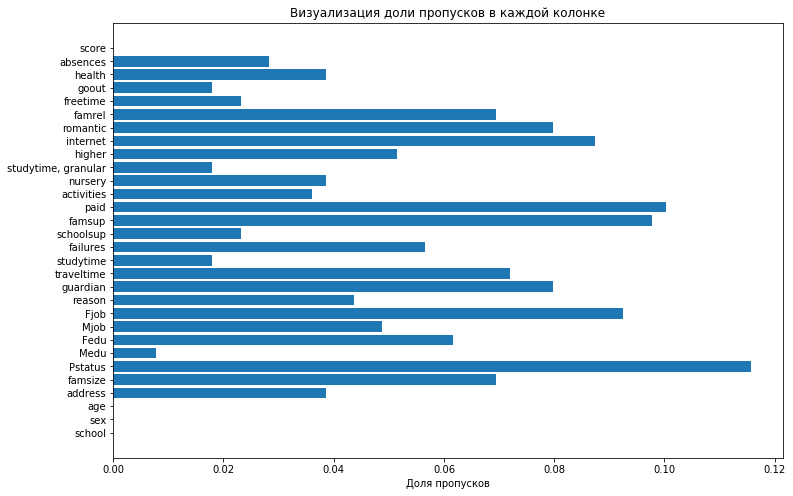

In [11]:
missings_describe()

Как видим даже в самом экстремальном случачае доля пропусков немногим превышает 0.1.  
Если пропуски находятся в одних и тех же строках, то не исключено, что будет возможно удаление таких строк без значительных потерь в объёме и качестве данных. Проверим:

In [12]:
print('После удаления всех строк с пропускми останется {} строк из {}.'.format(len(df.dropna()),len(df)))

После удаления всех строк с пропускми останется 97 строк из 389.


Увы, удаление всех строк с пропуском хотя бы в одной колонке оставляет нам менее четверти данных.

Узнаем нельзя ли улучшить ситуацию малой кровью, возможно можно сильно сократить пропуски удалив относительно небольшое количество наблюдений, посмторим на количество строк с соответсвующим количеством пропусков в строке:

In [13]:
df_miss_dist = pd.DataFrame(df.isna().sum(axis=1).value_counts().sort_index(ascending=False), 
                            columns=['Строк с таким количеством пропусков'])
df_miss_dist.index.name = "Количество пропусков в строке"
df_miss_dist.T

Количество пропусков в строке,6,5,4,3,2,1,0
Строк с таким количеством пропусков,2,5,15,43,97,130,97


Радикально уменьшить количество пропусков удалением малого количества наблюдений не получится. Поэтому с пропускам будем работать в дальнейшем отдельно в каждом признаке, что возможно позволит избежать нам таких значительных потерь в объёме данных.

### Ознакомимся с обобщенной информацией о данных.

Посмотрим на простую статистику

In [14]:
display(df.describe())
display(df.describe(include=[np.object]))

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,389.000000,386.000000,365.000000,361.000000,382.000000,367.000000,382.000000,362.000000,380.000000,382.000000,374.000000,378.000000,389.000000
mean,16.673522,2.766839,2.627397,1.434903,2.036649,0.326975,-6.109948,3.930939,3.223684,3.094241,3.529412,7.320106,52.262211
std,1.265662,1.094277,2.241790,0.692660,0.847239,0.729479,2.541716,0.931554,0.993364,1.116104,1.402006,23.615525,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,389,389,374,362,344,370,353,372,358,380,351,350,375,374,369,355,358
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,344,204,291,255,308,127,194,135,248,331,216,197,192,297,350,300,235


В числовых колонках похоже мы наблюдаем только дискретные величины. При этом у большинтсва этих дискретных величин всего несколько уникальных значений (это видно по значениям статистик **min, 25%, 50%, 75%, max** ). А вот колонка `score` возможно имеет больший набор значений и вполне может быть рапсределена "похоже на нормально" -  мода и среднее близки, "две сигмы" покрывают большую часть рапределения (заметно больше чем  от 1 до 3 го квартиля). В колонках `Fedu` и `famrel` похоже есть выбросы - нетипичные для набора данных значения, которые к тому же противоречат описанию признака.

В колонках со строковым типом данных представлены главным образом бинарные переменные, исключение - `Mjob`,`Fjob`,`reason` и`guardian`. Как можно заметить по статистике **freq** зачастую в признаках наблюдается несбалансированность по категориям, **top** категория может (например в `higher`) составлять до 95% всех значений.

Общий обзор данных на этом закончим и перейдем к детальному рассмотрению.

### Разделение на типы признаков: количественные, категориальные, бинарные
У нас будут разные подходы как в EDU так и в дальнейшей работе по отношению к разным типам признаков. Разделим признаки на количественные, категориальные и отдельно рассмотрим бинарные.  

Определим пороговое значение для отнесения признака к количественнуму, для этого посмотрим на начало списока количеств уникальных значений (без учета `NaN`) упорядоченный по убыванию 

In [15]:
df.nunique().sort_values(ascending=False).values[:10]

array([36, 18,  8,  6,  6,  5,  5,  5,  5,  5], dtype=int64)

Кажется разумным определить порог для количественного признака как ***'более 6'***, тогда:

- к количественным признакам отнесем те у котрых уникальных значений ***более 6***, числовой тип данных и смысл признака, согласно описанию позволяет отнести признак к количественным;
- к категориальным:
    - те у которых уникальных значений ***не более 6 и более 2*** и числовой тип данных
    - те у которых уникальных значений ***более 2*** и тип данных *object*
- к бинарным те у которых уникальных значений ***ровно 2***

*Признаков с одним уникальным значением (т.е. не несущим никакой информации) в наших данных нет.*

In [16]:
object_columns = df.columns[df.dtypes == np.object] 
digital_columns = df.columns[~(df.dtypes == np.object)] 

numerical_columns = digital_columns[df[digital_columns].nunique()>6]

categorical_columns = digital_columns[(df[digital_columns].nunique()>2) & (df[digital_columns].nunique()<=6)]
categorical_columns = categorical_columns.append(object_columns[(df[object_columns].nunique()>2)])

binary_columns = df.columns[df.nunique()== 2]

### Количественные признаки и целевая переменная

In [17]:
fstr = '{}, '* (len(numerical_columns)-1) + '{}'
print(('К количественным мы относим {} признака: ' + fstr).format(len(numerical_columns),*numerical_columns))

К количественным мы относим 3 признака: age, absences, score


Целевая переменная в нашей задаче `score`. В первую очередь рассмотим её.

#### score
согласно описанию - баллы по госэкзамену по математике.  
Признак принимает дискретные значения от 0 до 100  с шагом 5.  
Посмотрим на распределение

,0.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0,95.0,100.0
Количество учеников,37,1,7,15,9,31,27,54,46,31,31,27,33,16,6,12,5,1


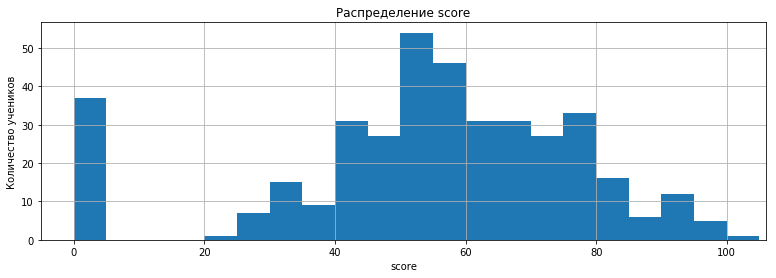

In [18]:
numericals_visualisation(df.score)

Как видим, значения находятся в дух четко разделяемых областях: 0 и интервал от 20 до 100, на котором `score` имеет некоторое напоминающее нормальное распределение с модой в 50. 

С одной стороны разумно предположить, что 0 - это еще одно обозначение/реализация пропущенного значения (работа не была написана, не была сдана, не была оценена по какой либо другой причине либо информация об оценке утеряна). Это предположение представляется вполне логичным, поскольку с устранением "нулевой" части распределения мы увидим интуитивно понятную, ожидаемую картину - приблизитльно нормальное распределение учеников по успехам в математике.  

С другой стороны формально перед нами стоит задача предсказать именно **результаты госэкзамена по математике**, а не успех в понимании курса вообще. И 37 нулевых оценок возможно являются именно зафиксированным в ведомостях результатом, а не заменой прочерка или другого обозначения отсутствия оценки. 

Видимо правильным будет в такой ситуации разбить задачу на две:

 - определение в какой из частей ("0" или "нормальная" область) находитмя оценка (задача бинарной классификации);
 - в случае "нормальной" части отдельно предсказание значения `score`(задача регрессии)
 
Введем еще одну целевую переменную - бинарный признак `zero_mark` и проведем EDU для двух целевых переменных.
В случае если EDU для бинарной целевой переменной покажет отсутствие полезных для модели признаков это будет означать, что оценки 0 случайным образом распределены и являются пропусками, которые следует удалить.

In [19]:
df['zero_mark'] = (df.score == 0).astype(int)

## "Нормальная" задача
Проведем сперва EDA задачи предсказания оценки из "нормальной" части распределения `score`, поскольку эту задачу нам необходимо решить безотносительно того удлаим ли мы  данные с `zero_mark` = 1 или станем предсказывать нахождение оценки в "нулевой" или "нормальной" области.

Действовать будем в таком порядке:  
продолжим исследовать количественные признаки для "нормальной" задачи, проведем отбор для построения модели;  
затем исследуем категориальные признаки, проведем их отбор;  
и в завершние проведем изучение бинарных признаков и их отбор;  
после чего перейдем к задаче "нулевой".

Набор данных для "нормальной" части:

In [20]:
dfn = (df[df.zero_mark == 0]).copy(deep=True)

В "нормальной" задаче мы имеем дело с таким рапределенеим целевой переменой:

,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0,95.0,100.0
Количество учеников,1,7,15,9,31,27,54,46,31,31,27,33,16,6,12,5,1


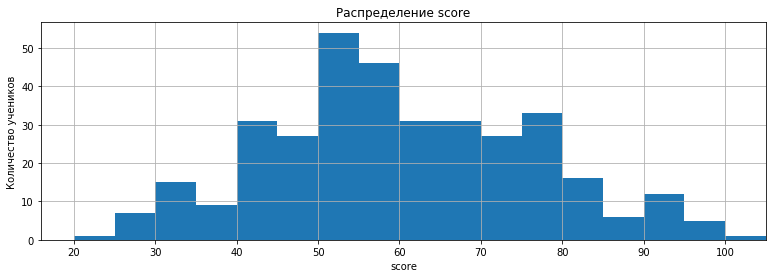

In [21]:
numericals_visualisation(dfn.score)

### Количественные признаки.

#### age 
согласно описанию это возраст ученика (от 15 до 22). Посмотрим на распределение признака:

,15,16,17,18,19,20,21,22
Количество учеников,76,96,90,69,16,3,1,1


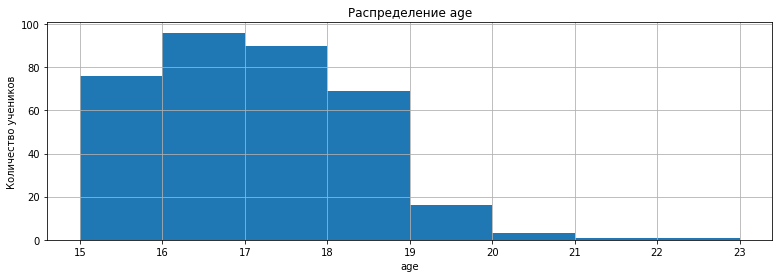

In [22]:
numericals_visualisation(dfn.age)

Как мы видим **age > 19** встречается крайне редко - всего 4 случая. Поскольку значнние уникальных значений признака не велико, возможно имеет смысл как один из вариантов работы с этим признаком отнести признак  к категориальным и в этом случае все категории **age > 19** (или **даже age > 18**) объеденить в одну.

Изучим признак в качестве категориального с таким преобразованием:

  age


Значения признака,15,16,17,18,19
Количество учеников,76,96,90,69,21


В age количество уникальных значений 5


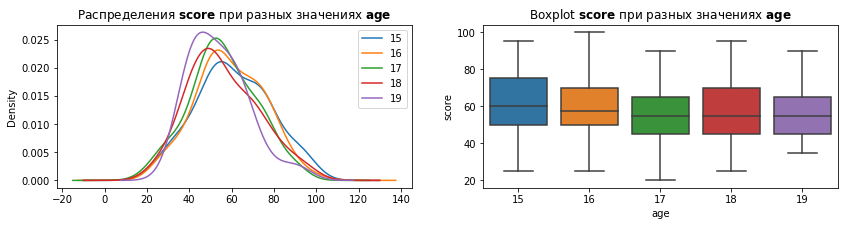

In [23]:
categoricals_visualisation(dfn.age.apply(lambda x: x if x<19 else 19))

Признак выглядит как могущий оказывать слабое влияние на `score`. Проверим его, применив тест Стьюдента к предположению о неразличимости распределений целевой переменной при разных значениях `age`. Уровень значимости примем равным  0.1

In [24]:
get_stat_dif(dfn.age.apply(lambda x: x if x<19 else 19),0.1)

Нет статзначимых различий для признака age


Т.е. в качестве категориального признак `age` не будем считать полезным для построения модели.

In [25]:
dfn.age.isna().sum()

0

Пропусков в этом признаке нет

#### absences
согласно описанию - количество пропущенных занятий

Поскольку частоты в распределении признака различается на пару порядков применим логарифмическую шкалу

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,...,21.0,22.0,23.0,24.0,25.0,26.0,28.0,30.0,38.0,40.0,54.0,56.0,75.0,212.0,385.0
Количество учеников,74,3,60,7,52,5,30,6,20,3,17,2,12,2,12,...,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1


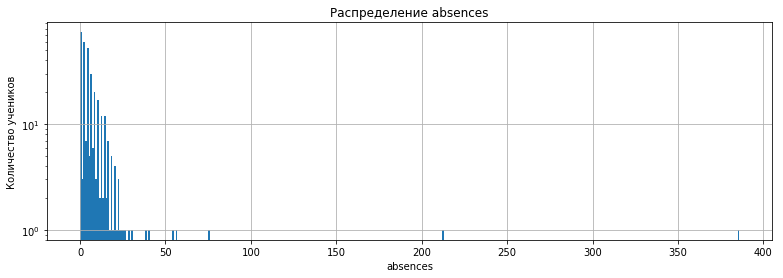

In [26]:
numericals_visualisation(dfn.absences,logscale=True)

В `absences` в правой части распределенния есть нексколько нетипичных значений - выбросов. Для удаления выбросов можно использрвать здравый смысл, описание признака и любую другую доступную нам иформацию либо воспользоваться формальным критерием. Исходя из здравого смысла 385, 212 и	даже 75 пропусков кажутся чрезмерными и они в любом случае нетипичны для нашего набора. С менее высокими значениями уже непросто - нам доподлино не известно количнество учебных дней в курсе (курс может занимать четверть, триместр, семестр, год и более) и то, сколько занятий в среднем приходится на день. Поэтому прибегнем к формальному критерию - для получения порога отнесения значения к выбросу воспользуемся формулой интерквартильного расстояния. В стандартном случае выбросом считаются такие значения, которые лежат вне рамок интервала

```
percentile(25) -1.5*IQR : percentile(75)+1.5*IQR
где де IQR = percentile(75) - percentile(25)
```

Чтобы не отбрасывать слишком много наблюдений модифицируем формулу и возьмем коэфициент при IQR равным 2 и примем во внимание только правую границу интервала. 

In [27]:
_, r_threshold = iqr_thresholds(dfn.absences,2)

ind_to_drop = dfn.absences[dfn.absences>r_threshold].index
dfn.drop(ind_to_drop,inplace = True)
df.drop(ind_to_drop,inplace = True) # для бинарной задачи тоже удалим выбросы

Посмотрим на признак после удаления значений, отнесеннных нами к выбросам.

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
Количество учеников,110,3,60,7,52,5,30,6,20,3,17,2,12,2,12,2,7,1,5,1,4


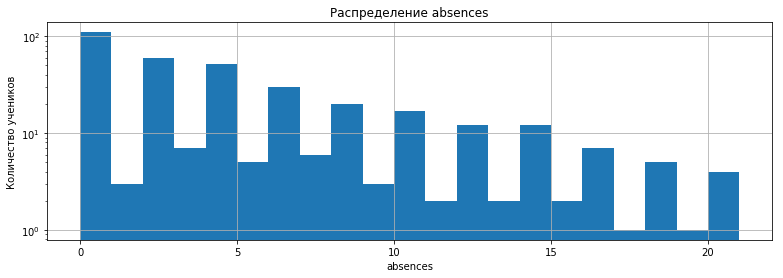

In [28]:
numericals_visualisation(df.absences,logscale=True)

В распределении заметно две характерных черты:  
  -  наличие пиков в четных значениях и провалов в нечетных (что по крайней мере на первый взгляд необычно)
  -  нисходящая тенденция в четных значениях, в нечетных значениях и как следствие нисходящая тенденция вцелом(это как раз нормально, даже ожидаемо).

Одна из возможных причин такого причудливого пилообразного распределения - учет пропусков ведется в академических часах, при этом занятия проводятся "парами". Соответсвенно и пропуски случаются как правило парами академических часов (редкий ученик опоздав на первую полупару придет на вторую).  
Если принять эту гипотезу, то можно попробовать избавится от пилообразности путем отнесения нечетного значения к одному из его четных соседей и посмотреть - улучшит ли это признак. На данном этапе такое преобразование мы проделывать не будем.

Пропусков в признаках всего 10.

In [29]:
dfn.absences.isna().sum()

10

Посмотрим на распределение целевой переменной на пропусках в `absences`

,40.0,50.0,60.0,75.0,85.0,90.0
Количество учеников,2,1,2,2,2,1


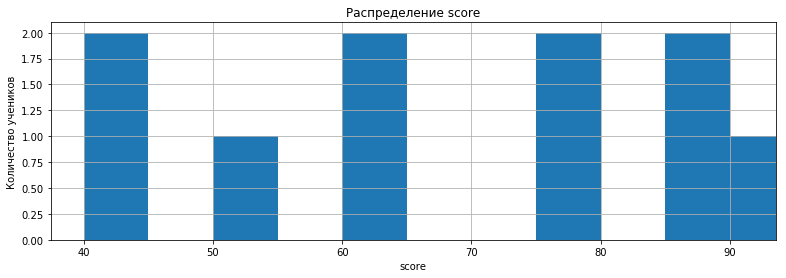

In [30]:
numericals_visualisation(dfn.score[df.absences.isna()])

Похоже, что пропуски случайны, поскольку распределение похоже на распределение случайной выборки из полного распределения `score`. Значит удаление пропусков не должно сильно испортить данные (удалять пока не будем).

#### Мультиколлинеарность и  корреляция с целевой переменной
Проверим отстутвие в количественных признаках сильной корреляции и посмотрим на корреляцию с целевой переменной (по умолчанию будем считать корреляцию Пирсона). 

In [31]:
display(dfn[numerical_columns].corr())

,age,absences,score
age,1.000000,0.20953,-0.129999
absences,0.209530,1.00000,-0.242220
score,-0.129999,-0.24222,1.000000


Как видим значение коэффициента корреляции количественных признаков между собой не угрожают мультиколлинеарностью.  
Корреляция признаков с целевой переменной далека от 1 но всё же существена (впрочем по поводу `age` сомнения есть).  
Стоит отметить, что знак коэффициента корреляции `score` с `absences` отрицательный, что легко интерпритируемо: больше пропусков - хуже успехи (коэффициент расчитанный с учётом "нулевых" наблюдений меньше по модулю и положительный, что плохо интерпретируется и кажется просто не имеет смысла).

Посмотрим на диаграммы рассеяния наших количественных признаков и целевой переменной.

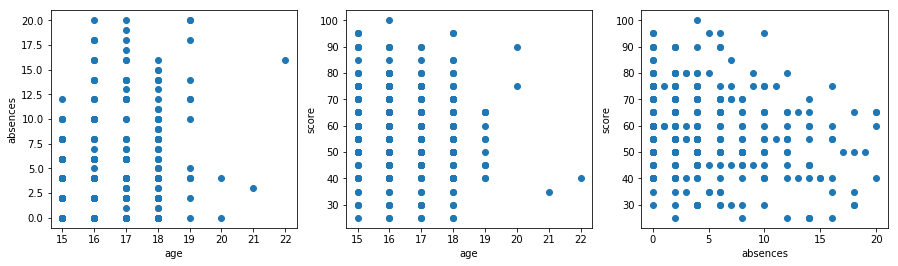

In [32]:
pairs = list(combinations(numerical_columns, 2))

plt.figure(figsize=(15,4))
for i,pair in enumerate(pairs):
        plt.subplot(1, 3, (i+1))
        plt.scatter(dfn[pair[0]], dfn[pair[1]])
        xlabel(pair[0])
        ylabel(pair[1])


Какие либо зависимости на первый взгляд не видны.

Оба количественных признака будем считать полезными для предсказания `score` моделью.

### Категориальные признаки

In [33]:
fstr = '{}, ' * (len(categorical_columns)-1) + '{}.'
print(('К категориальным мы относим {} признаков: ' + fstr).format(len(categorical_columns),*categorical_columns))

К категориальным мы относим 14 признаков: Medu, Fedu, traveltime, studytime, failures, studytime, granular, famrel, freetime, goout, health, Mjob, Fjob, reason, guardian.


Если посмотреть на названия колонок то обращает на себя внимания пара `studytime` и `studytime, granular` (в описании данных вторая колонка отсутсвует). При ближайшем рассмотрении оказывается, что:

In [34]:
df[['studytime','studytime, granular']].corr()

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


С этого момента категориальных признаков у нас 13, а не 14

In [35]:
dfn.drop(columns='studytime, granular', inplace=True)
df.drop(columns='studytime, granular', inplace=True) # не забудем и про бинарную задачу
categorical_columns = categorical_columns.drop('studytime, granular')

Теперь посмтотрим на значения, принимаемые категориальными признаками (мы помним, что некотрые значения в `Fedu` и `famrel` кажутся странными):

In [36]:
dfn[categorical_columns].apply(lambda x: sorted(x.dropna().unique().tolist()))

Medu                            [0.0, 1.0, 2.0, 3.0, 4.0]
Fedu                      [0.0, 1.0, 2.0, 3.0, 4.0, 40.0]
traveltime                           [1.0, 2.0, 3.0, 4.0]
studytime                            [1.0, 2.0, 3.0, 4.0]
failures                             [0.0, 1.0, 2.0, 3.0]
famrel                    [-1.0, 1.0, 2.0, 3.0, 4.0, 5.0]
freetime                        [1.0, 2.0, 3.0, 4.0, 5.0]
goout                           [1.0, 2.0, 3.0, 4.0, 5.0]
health                          [1.0, 2.0, 3.0, 4.0, 5.0]
Mjob          [at_home, health, other, services, teacher]
Fjob          [at_home, health, other, services, teacher]
reason                  [course, home, other, reputation]
guardian                          [father, mother, other]
dtype: object

Так и есть. Соотнеся описания признаков и наблюдаемые нами в данных значения признаков обнаружим что в `Fedu` и `famrel` есть выбросы, видимо это ошибки, исправим их:
- ошибочное значение 40.0 в `Fedu` разумно трактовать как 4.0 с лишним нулем;  
- ошибочное значение -1.0 в `famrel` разумно трактовать как 1.0 с ошибочным знаком.

In [37]:
dfn.Fedu.replace(40,4,inplace=True)
dfn.famrel.replace(-1,1,inplace=True)

df.Fedu.replace(40,4,inplace=True) 
df.famrel.replace(-1,1,inplace=True)

Так же есть несоответствие с описанем у призанака `failures`. Согласно описанию  - *количество внеучебных неудач (n, если 1<=n<3, иначе 4)*. Т.е. признак должен принимать значения 1.0, 2.0, 4.0. В наборе видим 0.0, 1.0, 2.0, 3.0. Ряд значений в наборе выглядит более логичным (например согласно опсанию и 0 и более 2 пропусков кодируется 4, что озадачивает), потому будем считать что в этом признаке ошибка не в данных, а в описании и реальный смысл признака примем как *количество внеучебных неудач (n, если 0<=n<3, иначе 3)*.

Посмотим на общее количество пропусков в категориальных признаках и на таблицу количества пропусков в каждом из признаков.

In [38]:
print('Всего в категориальных признаках {} строк с пропусками'.format(dfn[categorical_columns].isna().any(axis=1).sum()))
display(pd.DataFrame(dfn[categorical_columns].isna().sum(), columns=['Пропусков']).T)

Всего в категориальных признаках 155 строк с пропусками


,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,Mjob,Fjob,reason,guardian
Пропусков,2,20,23,7,17,23,6,6,13,15,31,15,28


Посмотрим на:
- таблицы распределения признаков;
- распределения `score` при разных значениях признака;
- Boxplot-ы `score` при разных значениях признака;
- так же укажаем количество уникальных значений в признаке. 

Это поможет нам понять какие категориальные признаки оказывают влияние на целевую переиенную `score` и соответсвенно какие из них стоит отбрать для построения модели.

  Medu


Значения признака,0.0,1.0,2.0,3.0,4.0
Количество учеников,3,47,84,81,118


В Medu количество уникальных значений 5


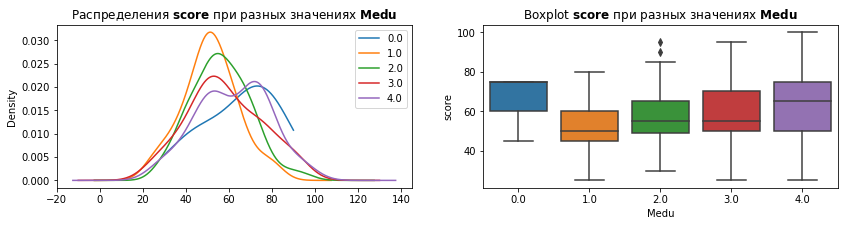

  Fedu


Значения признака,0.0,1.0,2.0,3.0,4.0
Количество учеников,2,65,89,82,77


В Fedu количество уникальных значений 5


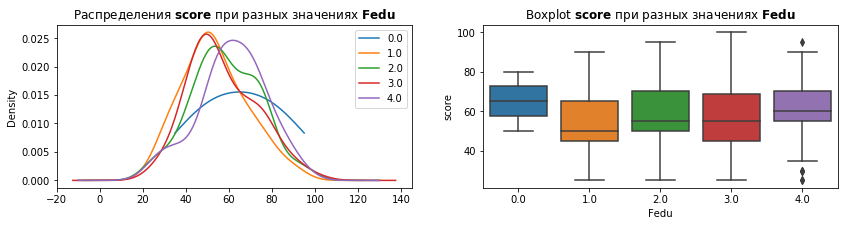

  traveltime


Значения признака,1.0,2.0,3.0,4.0
Количество учеников,210,78,17,7


В traveltime количество уникальных значений 4


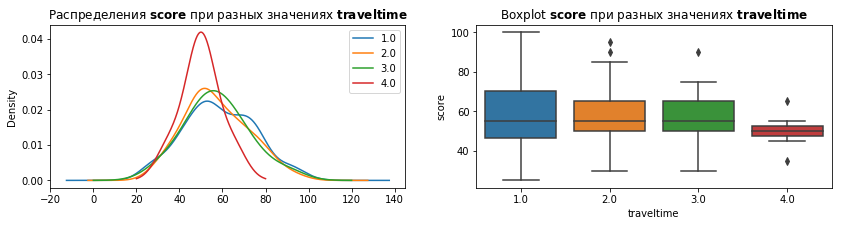

  studytime


Значения признака,1.0,2.0,3.0,4.0
Количество учеников,86,162,56,24


В studytime количество уникальных значений 4


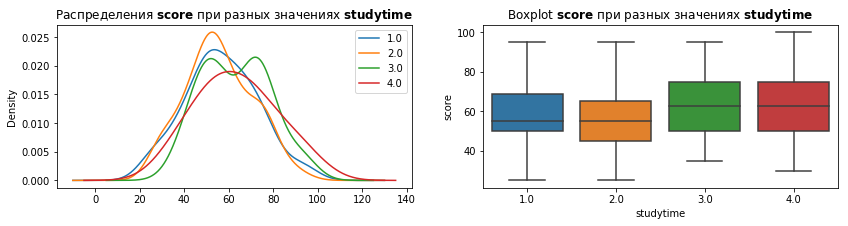

  failures


Значения признака,0.0,1.0,2.0,3.0
Количество учеников,266,33,9,10


В failures количество уникальных значений 4


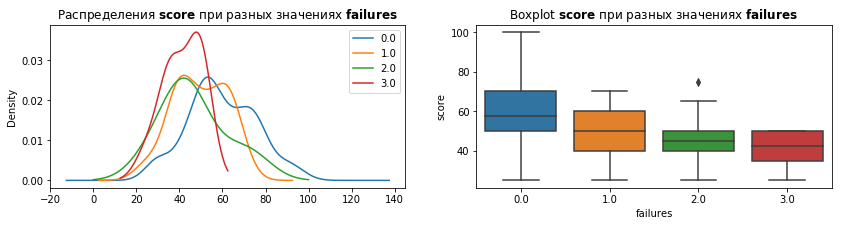

  famrel


Значения признака,1.0,2.0,3.0,4.0,5.0
Количество учеников,7,13,52,155,85


В famrel количество уникальных значений 5


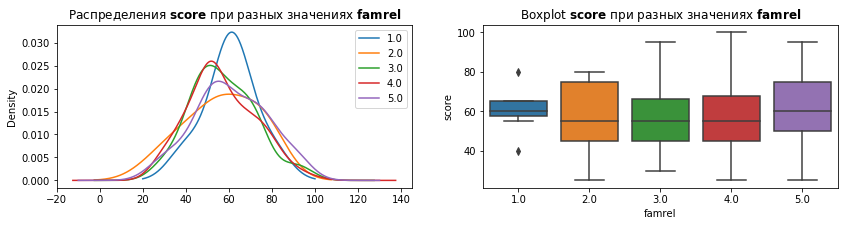

  freetime


Значения признака,1.0,2.0,3.0,4.0,5.0
Количество учеников,13,55,127,100,34


В freetime количество уникальных значений 5


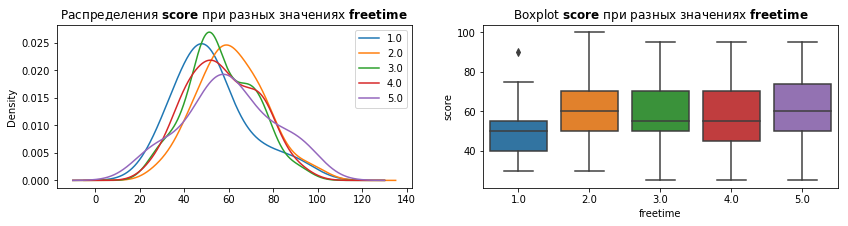

  goout


Значения признака,1.0,2.0,3.0,4.0,5.0
Количество учеников,17,88,114,69,41


В goout количество уникальных значений 5


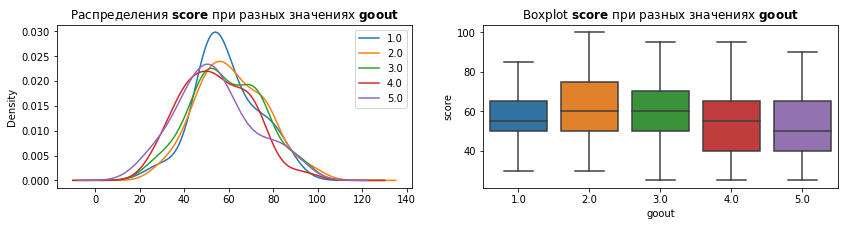

  health


Значения признака,1.0,2.0,3.0,4.0,5.0
Количество учеников,42,33,77,51,119


В health количество уникальных значений 5


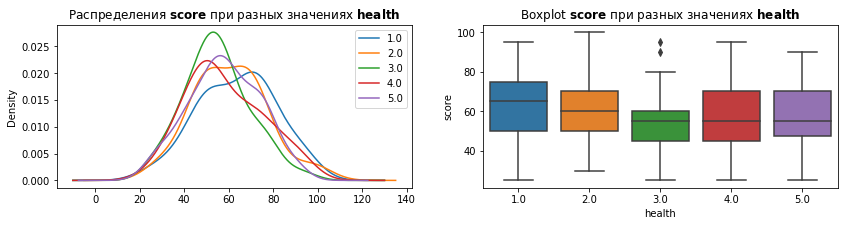

  Mjob


Значения признака,at_home,health,other,services,teacher
Количество учеников,48,30,109,83,50


В Mjob количество уникальных значений 5


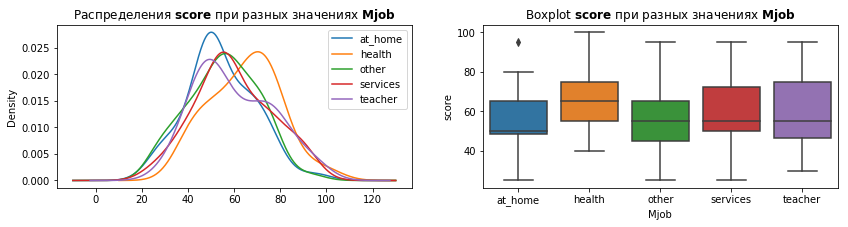

  Fjob


Значения признака,at_home,health,other,services,teacher
Количество учеников,14,15,169,82,24


В Fjob количество уникальных значений 5


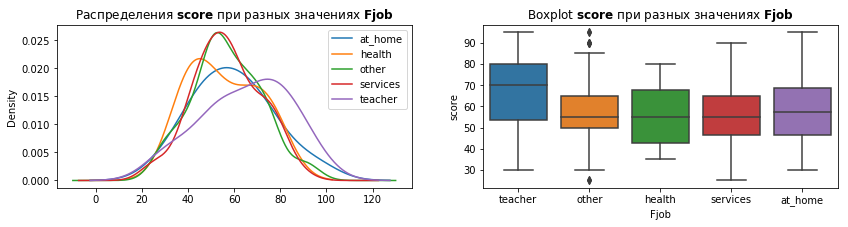

  reason


Значения признака,course,home,other,reputation
Количество учеников,117,80,32,91


В reason количество уникальных значений 4


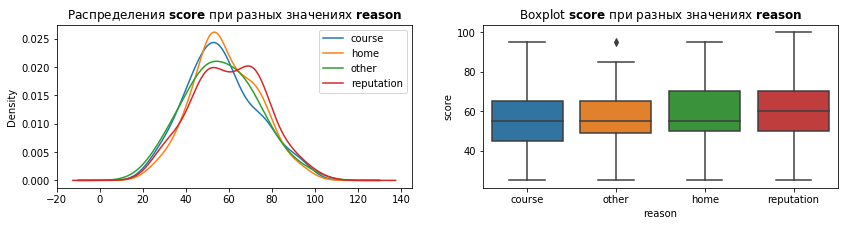

  guardian


Значения признака,father,mother,other
Количество учеников,77,213,17


В guardian количество уникальных значений 3


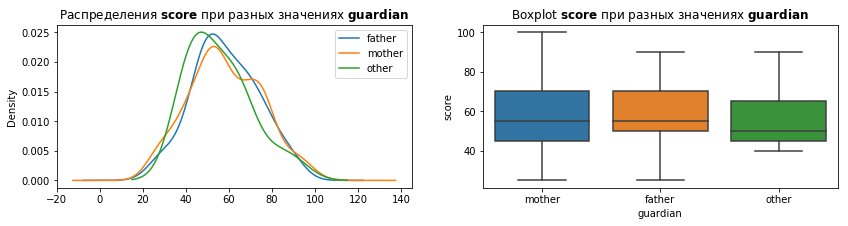

In [39]:
for column in categorical_columns: categoricals_visualisation(dfn[column])

Можно заметить что некоторые признаки очевидно имеют значительное влияние на score (например `failures`), некоторые оказывают влияние, хоть и не такое сильное ( например `Mjob`, `Fjob`, `health`, `goout`), но так же есть признаки влияние которых, судя по графикам, совсем незначительно (например `reason` или `guardian`).
Предварительно к полезным для модели следует отнести все кроме `reason` и `guardian`

Стоит отметить, что между некоторыми категориальными признаками похоже есть заметная корреляция - например распределения и boxplot-ы `Medu` и `Fedu` довольно похожи.  

Для подтверждения предварительных вывоводов о полезности признаков обратимся к  статистическому анализу - проведдем тест Стьюдента для каждого признака о неразличимости распределений целевой переменной при разных значениях признака.  
Уровень значимости примем равным 0.1

In [40]:
for column in categorical_columns: get_stat_dif(dfn[column], 0.1) 

Найдены статистически значимые различия для признака Medu
Найдены статистически значимые различия для признака Fedu
Нет статзначимых различий для признака traveltime
Найдены статистически значимые различия для признака studytime
Найдены статистически значимые различия для признака failures
Нет статзначимых различий для признака famrel
Нет статзначимых различий для признака freetime
Найдены статистически значимые различия для признака goout
Найдены статистически значимые различия для признака health
Найдены статистически значимые различия для признака Mjob
Нет статзначимых различий для признака Fjob
Нет статзначимых различий для признака reason
Нет статзначимых различий для признака guardian


По результатм отберем для построения модели следующие категориальные признаки:  `Medu`, `Fedu`, `Mjob`, `studytime`, `failures`, `goout`, `health`. Зависимость от некоторых этих признаков выглядит абсолютно логичной (`studytime`,`failures`, `health`), от других - вполне возможной.

### Бинарные признаки

In [41]:
fstr = '{}, '* (len(binary_columns)-1) + '{}'
print(('К бинарным мы относим {} признаков: ' + fstr).format(len(binary_columns),*binary_columns))

К бинарным мы относим 13 признаков: school, sex, address, famsize, Pstatus, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic


Посмотрим на количество пропусков в бинарных признаках в целом и в каждом признаке отдельно.

In [42]:
print('Всего в бинарных признаках {} строк с пропусками'.format(dfn[binary_columns].isna().any(axis=1).sum()))
display(pd.DataFrame(df[binary_columns].isna().sum(), columns=['Пропусков']).T)

Всего в бинарных признаках 187 строк с пропусками


,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
Пропусков,0,0,15,25,40,9,34,38,14,15,19,33,30


Теперь изучим:
- рапсределения признаков (количество учеников и доля учеников для каждого из двух значений признака);
- распределения `score` при двух разных значениях признака;
- Boxplot-ы `score` при двух разных значениях признака;

Это поможет нам понять какие бинарные признаки оказывают влияние на целевую переиенную `score` и соответсвенно какие из них стоит отбрать для построения модели.

  school


Значения признака,GP,MS
кол-во учеников,295.000000,40.000000
доля учеников,0.880597,0.119403


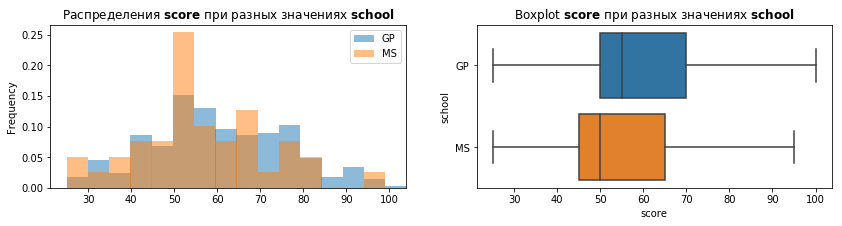

  sex


Значения признака,F,M
кол-во учеников,169.000000,166.000000
доля учеников,0.504478,0.495522


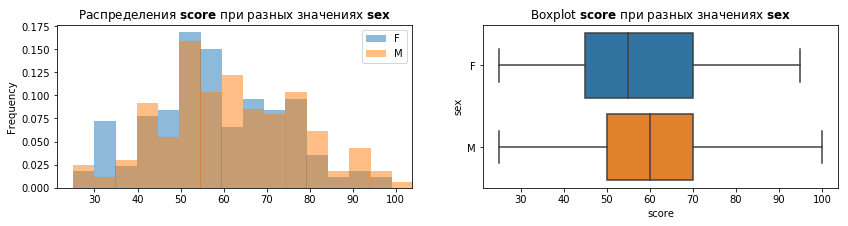

  address


Значения признака,R,U
кол-во учеников,71.000000,250.000000
доля учеников,0.221184,0.778816


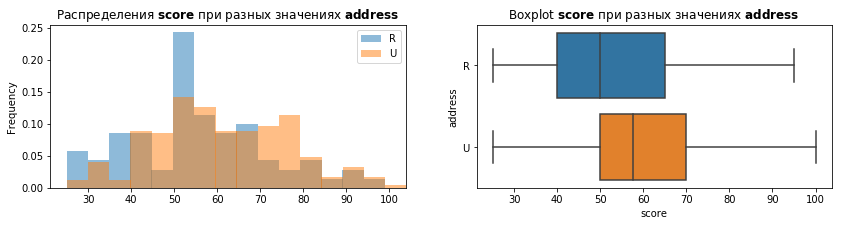

  famsize


Значения признака,GT3,LE3
кол-во учеников,216.000000,97.000000
доля учеников,0.690096,0.309904


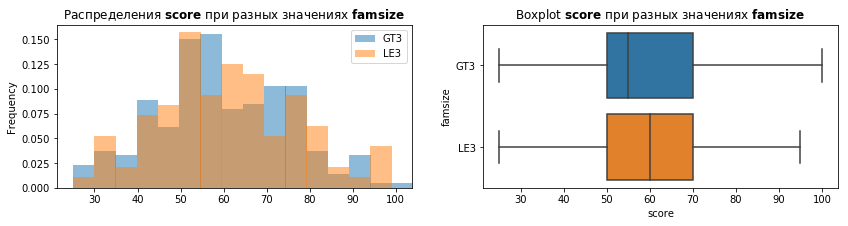

  Pstatus


Значения признака,A,T
кол-во учеников,30.000000,269.000000
доля учеников,0.100334,0.899666


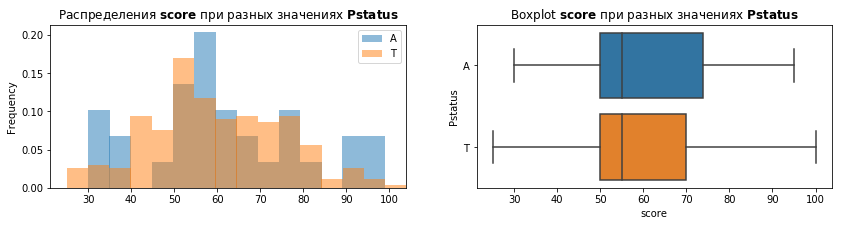

  schoolsup


Значения признака,no,yes
кол-во учеников,281.000000,45.000000
доля учеников,0.861963,0.138037


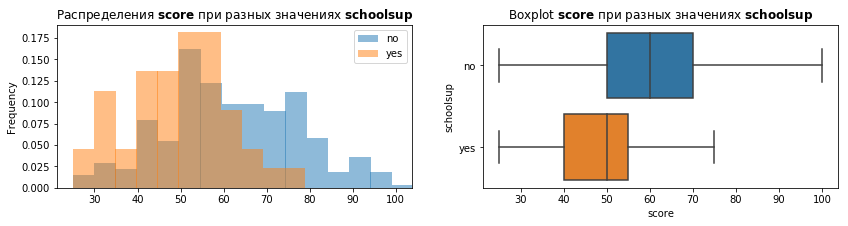

  famsup


Значения признака,no,yes
кол-во учеников,116.000000,187.000000
доля учеников,0.382838,0.617162


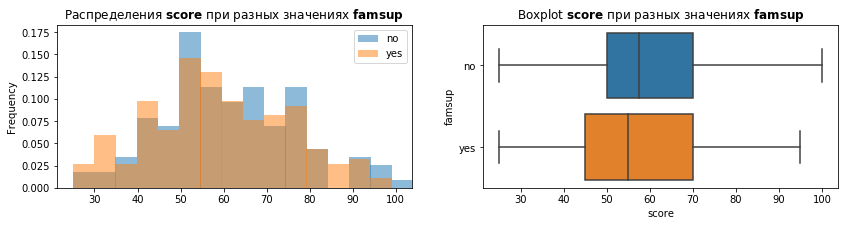

  paid


Значения признака,no,yes
кол-во учеников,164.000000,136.000000
доля учеников,0.546667,0.453333


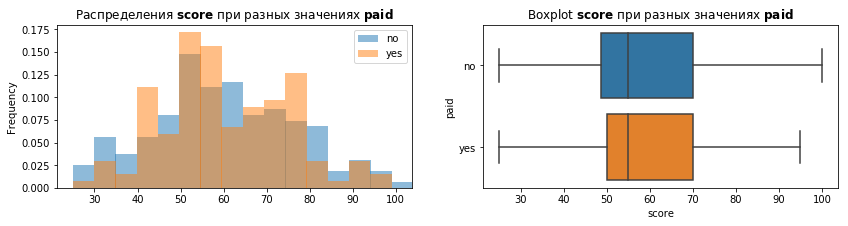

  activities


Значения признака,no,yes
кол-во учеников,156.000000,167.000000
доля учеников,0.482972,0.517028


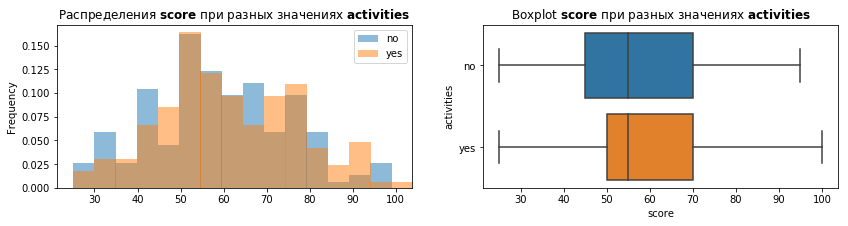

  nursery


Значения признака,no,yes
кол-во учеников,65.000000,258.000000
доля учеников,0.201238,0.798762


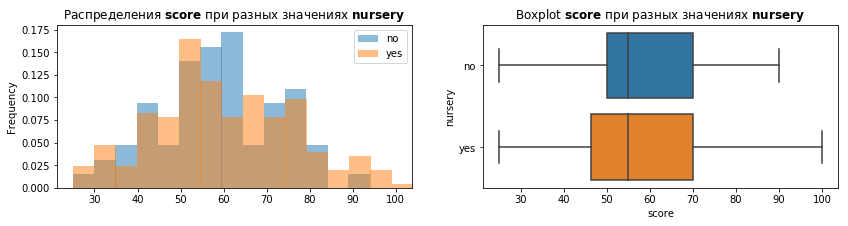

  higher


Значения признака,no,yes
кол-во учеников,12.000000,305.000000
доля учеников,0.037855,0.962145


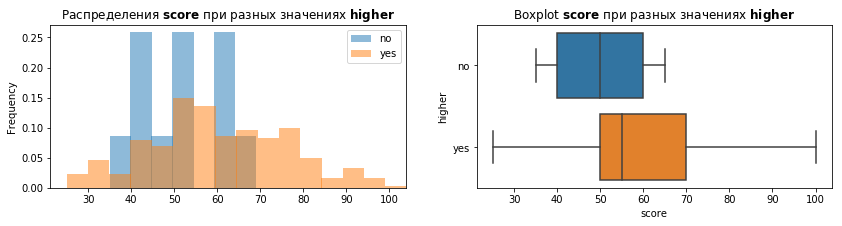

  internet


Значения признака,no,yes
кол-во учеников,48.000000,259.000000
доля учеников,0.156352,0.843648


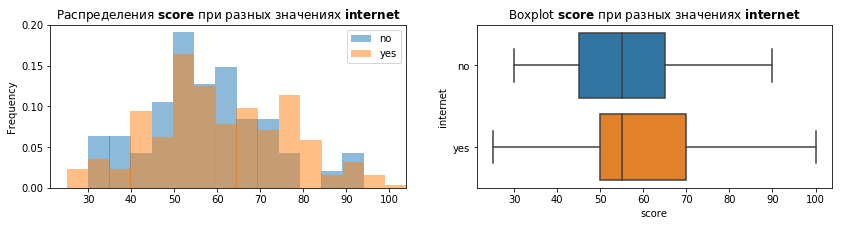

  romantic


Значения признака,no,yes
кол-во учеников,213.000000,94.000000
доля учеников,0.693811,0.306189


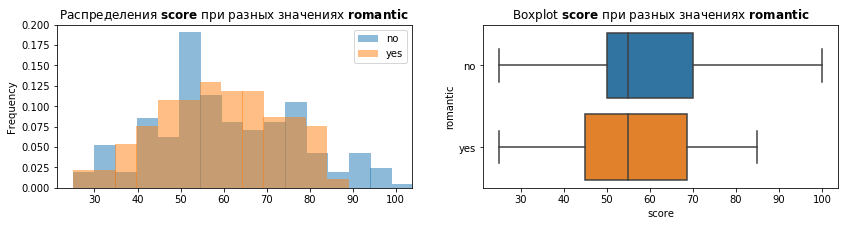

In [43]:
for column in binary_columns: binary_visualisation(dfn[column])

Судя по гистограммам рапределений и boxplot-ам некоторые бинарные признаки (например  `address`, `schoolsup`, `higher`) имеют значительное различие в распределениях целевой переменной при разных значениях признака, некоторые имеют различие, хоть и не такое сильное ( например `school`, `sex`), а некоторые признаки сразу представляютя малополезными( наприммер `paid`, `nursery`)
Проблему может вызвать сильная несбалансированнсть по значениям признака. Например в `higher` распределения сильно отличаются, но это отличие выделяет только 12 наблюдений, что наверное сделает признак не очень полезным.
Предварителный анализ позволяет отнести к потенциально полезным все признаки кроме  `paid` и `nursery`

Для подтверждения предварительных вывоводов обратимся к статистическому анализу - проведдем тетст Стьюдента для каждого признака о неразличимости распределений целевой переменной при двух разных значениях признака.
Уровень занчимоти примем равным 0.1

In [44]:
for column in binary_columns: get_stat_dif(df[column], 0.1) 

Нет статзначимых различий для признака school
Найдены статистически значимые различия для признака sex
Найдены статистически значимые различия для признака address
Нет статзначимых различий для признака famsize
Нет статзначимых различий для признака Pstatus
Найдены статистически значимые различия для признака schoolsup
Нет статзначимых различий для признака famsup
Нет статзначимых различий для признака paid
Нет статзначимых различий для признака activities
Нет статзначимых различий для признака nursery
Нет статзначимых различий для признака higher
Нет статзначимых различий для признака internet
Нет статзначимых различий для признака romantic


По результатм отберем для построения модели следующие бинарные признаки: `sex`, `address`, `schoolsup`. 

## "Бинарная" задача
Теперь проведем EDA бинарной задачи.  

Рапределение `zero_mark` выглядит так.

Значения признака,0,1
кол-во учеников,335.000000,37.000000
доля учеников,0.900538,0.099462


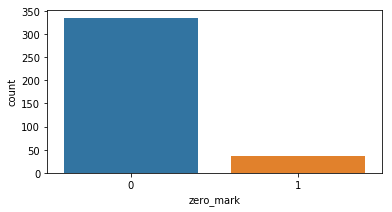

In [45]:
stud_num = df.zero_mark.value_counts()
stud_prop = df.zero_mark.value_counts(normalize=True)
df_disp = pd.DataFrame({'кол-во учеников':stud_num,'доля учеников':stud_prop})
df_disp.index.name = 'Значения признака'
display(df_disp.T)

plt.figure(figsize=(6,3))
sns.countplot(df.zero_mark);

Визуализируем распределения `zero_mark` при разных значениях признаков и попытаемся увидеть насколько разняться эти распредеоения и найти те признаки, разница в которых наиболее заметна. Произведем таким образом предварительный отбор полезных признаков.  

Затем проведем статистический анализ  - для каждого признака реализуем тест Стьюдента  о неразличимости распределений целевой бинарной переменной (т.е. разности пропорций) при разных значениях признака. Таким образом окончательно выберем признаки для модели предсказывающей в какой из частей ("0" или "нормальная" область) находитмя оценка.

Если признаки найдутся, проверим пропуски.

Визуализация представлена ниже:

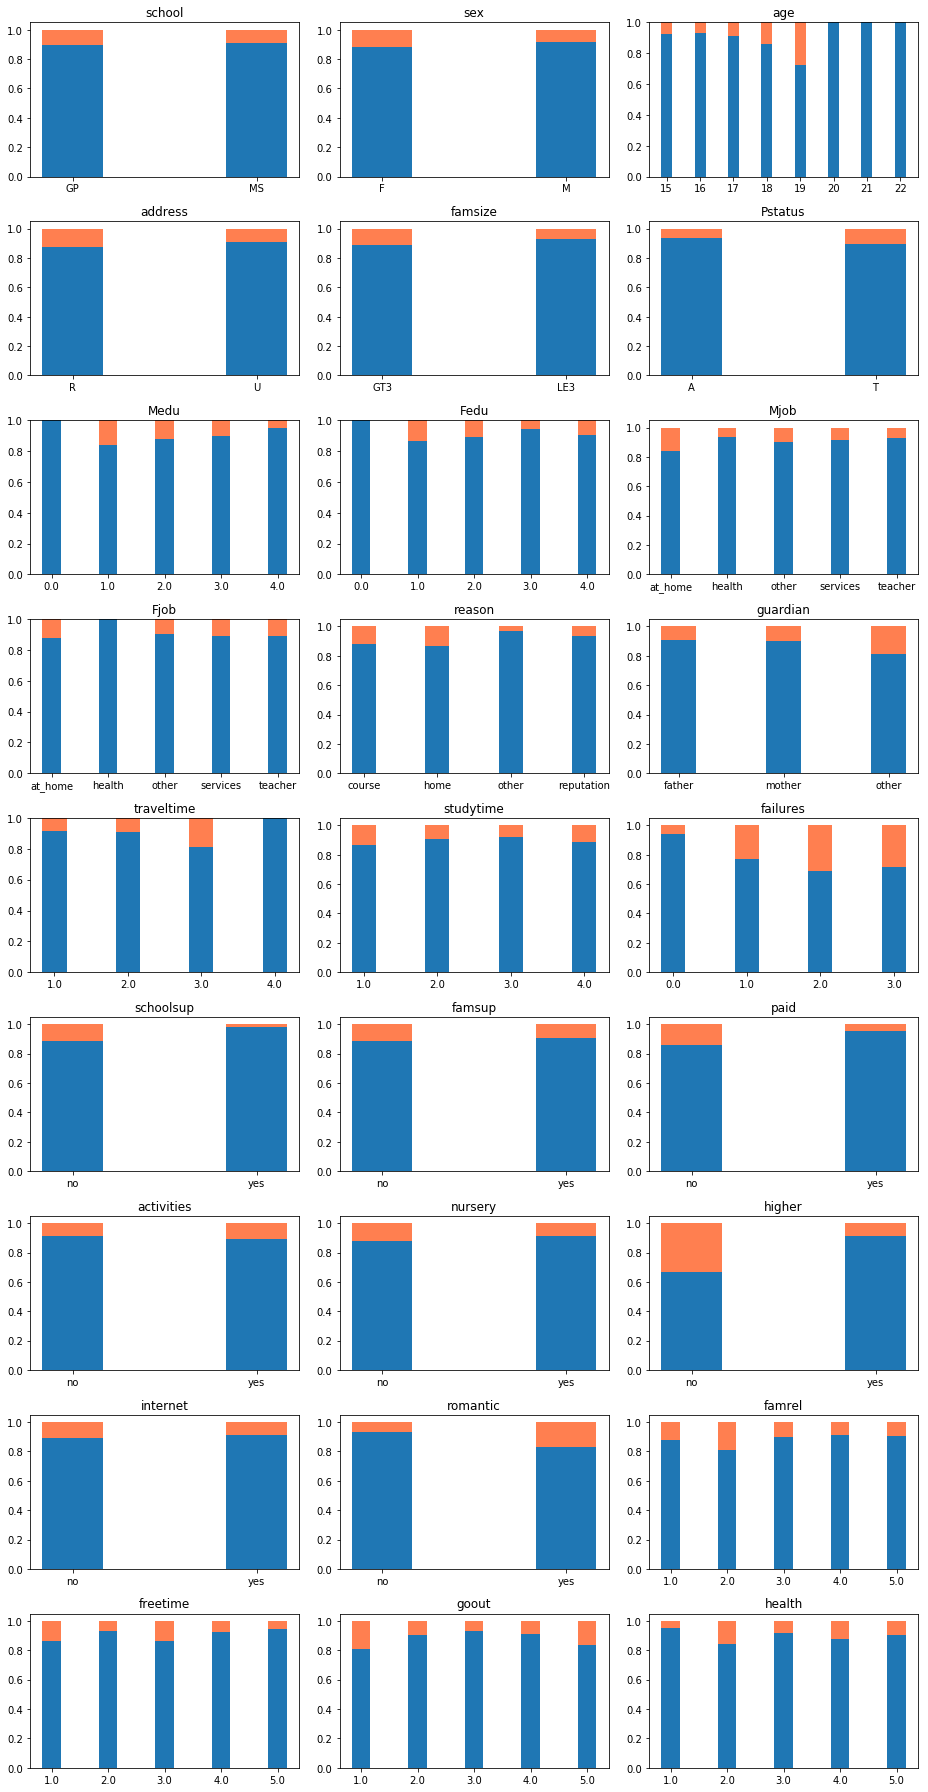

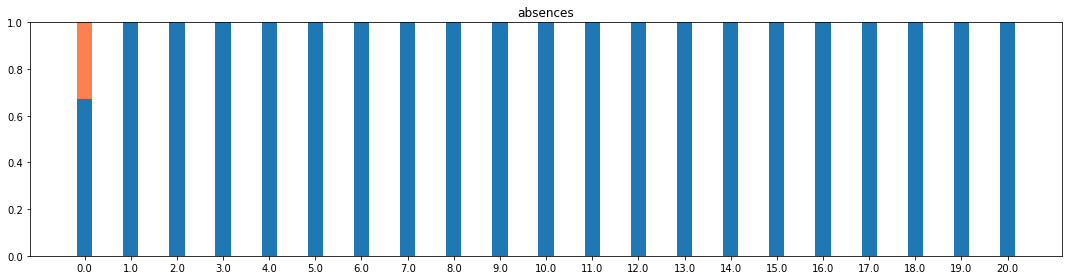

In [46]:
binary_task_visualization()

Обращает на себя внимание признак `absences` - он определенно оказывает значительное влияние на `zero_mark`. Так же скорее всего заметное влияние оказывают `age`, `failures`, `higher`. Совсем незначительное влияние ожидается у `school`, `famsize`, `studytime`, `famsup`, `activities`, `internet`. У прочих признаков влияние просматривается, возможно они полезны.

Проведем статистический анализ.

In [47]:
for column in df.columns.drop(['score', 'zero_mark']):
    get_stat_dif_prop(df[column])

Нет различий для колонки school
Нет различий для колонки sex
Нет различий для колонки age
Нет различий для колонки address
Нет различий для колонки famsize
Нет различий для колонки Pstatus
Нет различий для колонки Medu
Нет различий для колонки Fedu
Нет различий для колонки Mjob
Нет различий для колонки Fjob
Нет различий для колонки reason
Нет различий для колонки guardian
Нет различий для колонки traveltime
Нет различий для колонки studytime
Найдены статистически значимые различия для колонки failures
Нет различий для колонки schoolsup
Нет различий для колонки famsup
Найдены статистически значимые различия для колонки paid
Нет различий для колонки activities
Нет различий для колонки nursery
Найдены статистически значимые различия для колонки higher
Нет различий для колонки internet
Найдены статистически значимые различия для колонки romantic
Нет различий для колонки famrel
Нет различий для колонки freetime
Нет различий для колонки goout
Нет различий для колонки health
Найдены статистич

По результатм отберем для построения модели следующие признаки: `failures`, `paid`, `higher`, `romantic`, `absences`

Посмотри мна пропуски в этих колонках

In [48]:
columns_for_binary = ['failures', 'paid', 'higher', 'romantic', 'absences']
df_for_binary_model = df[columns_for_binary]

print('Всего признаках {} строк с пропусками'.format(df_for_binary_model.isna().any(axis=1).sum()))
display(pd.DataFrame(df_for_binary_model.isna().sum(), columns=['Пропусков']).T)

Всего признаках 99 строк с пропусками


,failures,paid,higher,romantic,absences
Пропусков,19,38,19,30,11


## Итоги

В признаках зачастую наблюдается значительная несбалансированность по количеству разных категорий, что может быть проблемой для обучения обоих моделей.

Выбросы/ошибки встречаются только в 3 колонках (из них два признака были отобраны для регресси и ни одного для классификации) и их количество невелико по отношению к количеству всех наблюдений. По этому параметру данные можно считать достаточно качественными.

Количество пропусков в  предоставленных даных и их распределение по наблюдениям не позволяет решить проблему удалением наблюдений с пропусками. Т.е. при относительно небольшой доле пропусков в обьеме всех данных (менее 5% от всего обьема) они все же создают существенную проблему. В дальнейшем придется обрабатывать пропуски в каждом признаке индивидуально, статарясь свести к минимуму потери в количестве и качестве информации. 

### "Нормальная" задача
В результате приведенного EDU для построения "нормальной" модели были отобраны признаки **column_for_model**

In [49]:
column_for_norm = ['age', 'absences', 'Medu', 'Fedu', 'Mjob', 'studytime', 'failures',
                    'goout', 'health', 'sex', 'address', 'schoolsup']

Данные для построения модели - **df_for_model**

In [50]:
df_for_norm = dfn[column_for_norm]

Псмотрим на обобщенную информацию об этих данных

In [51]:
df_for_norm.info(max_cols = 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 394
Columns: 12 entries, age to schoolsup
dtypes: float64(7), int64(1), object(4)
memory usage: 44.0+ KB


Количество наблюдений сократилось с начальных 395 до 335.  
Из исходных 28 были отобронны 12 признаков.  

Среди отобранных 2 количественных признака, 7 категориальных и 3 бинарных.  
4 признака имеют тип данных *object* , в дальнейшем их придется преобразовывать в числовой вид.

### "Бинарная" задача
EDU для "бинарной" задачи дало нам следующий список признаков для построения модели

In [52]:
columns_for_binary

['failures', 'paid', 'higher', 'romantic', 'absences']

Посмотрим на информацию об отобранных данных для этой задачи

In [53]:
df_for_binary = df[columns_for_binary]
df_for_binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 0 to 394
Data columns (total 5 columns):
failures    353 non-null float64
paid        334 non-null object
higher      353 non-null object
romantic    342 non-null object
absences    361 non-null float64
dtypes: float64(2), object(3)
memory usage: 27.4+ KB


Количество наблюдений сократилось с начальных 395 до 372.  
Из исходных 28 были отобронны 5 признаков.